In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [93]:
raw_train = pd.read_csv('input/train.csv')

In [118]:
df_train = raw_train

# Remove missing data

total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]

df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

# Remove outliers

df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

# Make sure SalePrice, GrLivaArea, and TotalBsmtSF are normally distributed to satisfy some assumptions of the ML algorithms

df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
df_train.loc[df_train['TotalBsmtSF'] > 0, 'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

y_std = np.std(df_train['SalePrice']) # for later

# Standardize numerical attributes
cat_attribs = list(df_train.dtypes[df_train.dtypes == object].index) + ['MSSubClass']
num_attribs = list(set(df_train.columns).difference(cat_attribs))
df_train[num_attribs] = StandardScaler().fit_transform(df_train[num_attribs])

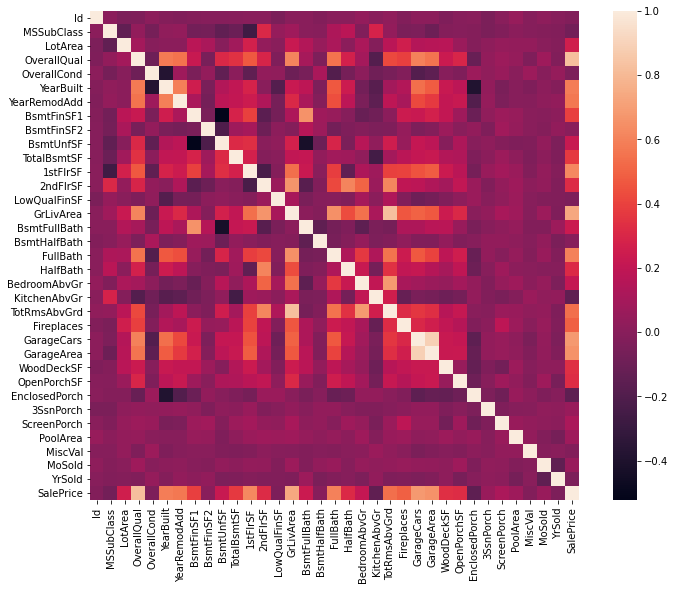

In [119]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True)

In [120]:
# Detect features with high correlation

for colno, col in enumerate(corrmat.columns):
    for rowno, value in enumerate(corrmat[col]):
        if np.abs(value) > 0.8:
            row = corrmat.index[rowno]
            if rowno < colno and 'SalePrice' not in [row, col]:
                print(row, col, value)

GrLivArea TotRmsAbvGrd 0.823003720240041
GarageCars GarageArea 0.8874424754231395


In [121]:
# Drop features that are highly correlated or can't help us

to_drop = ['Id', 'TotRmsAbvGrd', 'GarageCars']
if set(to_drop).issubset(df_train.columns):
    df_train = df_train.drop(to_drop, axis=1)

In [122]:
# One-hot encode categorical features

if set(cat_attribs).issubset(df_train.columns):
    df_train = pd.get_dummies(df_train, columns=cat_attribs)

In [123]:
# Repeat the above process

to_drop = []
corrmat = df_train.corr()
for colno, col in enumerate(corrmat.columns):
    for rowno, value in enumerate(corrmat[col]):
        if np.abs(value) > 0.8:
            row = corrmat.index[rowno]
            if rowno < colno and 'SalePrice' not in [row, col]:
                #print(row, col, value)
                to_drop.append(row)

print("Dropping redundant features:", *to_drop)
df_train = df_train.drop(to_drop, axis=1)
n_features = len(df_train.columns) - 1
print(f"{n_features} features left")

Dropping redundant features: MSZoning_RL Street_Grvl LotShape_IR1 Utilities_AllPub LandSlope_Gtl MSZoning_FV 2ndFlrSF RoofStyle_Gable RoofStyle_Flat Exterior1st_AsbShng Exterior1st_CBlock Exterior1st_CemntBd Exterior1st_HdBoard Exterior1st_MetalSd Exterior1st_VinylSd Exterior1st_Wd Sdng ExterQual_Gd ExterCond_Gd CentralAir_N Electrical_FuseA KitchenQual_Gd PavedDrive_N SaleType_New HouseStyle_1.5Unf HouseStyle_1.5Fin HouseStyle_SLvl BldgType_Duplex BldgType_2fmCon
203 features left


In [124]:
X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice']

In [130]:
def display_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(rmse)

    factor = np.exp(y_std * rmse)
    print(f"On average, the regressor is off by a factor of {factor}")

In [131]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
display_metrics(y_train, y_pred)

0.235931248843275
On average, the regressor is off by a factor of 1.0988952475014258


In [132]:
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
display_metrics(y_train, y_pred)

0.2210693240228112
On average, the regressor is off by a factor of 1.092386567677949


In [135]:
model = SGDRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
display_metrics(y_train, y_pred)

0.2712354893336204
On average, the regressor is off by a factor of 1.1145124040364942
